## Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# display settings
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [8, 8]

# parse the csv file
df = pd.read_csv("data.csv", sep=";")
df.head()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


## Clean Data

All strings were converted to lower case and special characters and numbers were removed. The "Betrag" column has mixed decimal seperators and had to be fixed as well.

I removed all columns that are not used as features later on to make the tables more readable.

In [21]:
import re

def clean_string(string):
    string = string.lower()
    string = re.sub(r"[^a-zäöü]+", " ", string)
    return string

def clean_dataset(dataset):
    # clean strings
    dataset["Verwendungszweck"] = dataset["Verwendungszweck"].map(clean_string)
    dataset["Buchungstext"] = dataset["Buchungstext"].map(clean_string)
    dataset["Beguenstigter/Zahlungspflichtiger"] = dataset["Beguenstigter/Zahlungspflichtiger"].map(clean_string)
    
    # fix decimal commas/points in Betrag
    dataset["Betrag"] = dataset["Betrag"].map(lambda x : float(str(x).replace(",", ".")))
    
    # remove columns that are not used for classification
    return dataset.drop(["Unnamed: 0", "Auftragskonto", "Buchungstag", "Valutadatum", "Kontonummer", "BLZ", "Betrag", "Waehrung"], axis=1, errors="ignore")

df = clean_dataset(df);
df.head()

,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,label
0,lohn gehalt,gehalt adorsys gmbh co kg end to end ref notpr...,adorsys gmbh co kg,income
1,miete,byladem sbt de miete beuthener str end to end ...,georg tasche,living
2,bargeld,uhr nuernberg all eur geb eur einzahlung ausz...,bargeld,private
3,lebensmittel getraenke,edeka neubauer nuernb nuernb t kfn vj lastsch...,kartenzahlung,standardOfLiving
4,spontanausgabe,amazon,neue playstation,leisure


## Split data into training and test dataset

25% of the dataset is set aside and used for evaluation later on. Since the dataset is inbalanced (classes are not distributed evenly) I use the `stratify` option which tries to preserve the distribution. The fixed `random_state` ensures that the dataset is split exactly the same way on every execution of the jupyter notebook.

In [3]:
from sklearn.model_selection import train_test_split

X = df.copy().drop(["label"], axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

## Feature extraction

Since the naive bayes classifier can only work on numeric feature vectorsm I had to convert the strings to numbers first. I used the bag of words model where each string is converted to a vector that represents how often a word occured in a string.

The vocabulary is created from the training dataset and I kept only words that occure in more than one transaction.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# filters words that occur only in one transaction
def create_vocabulary(strings, min_occurances=2):
    cv = CountVectorizer()
    cv.fit(strings)
    counts = cv.transform(strings).toarray()
    words = cv.get_feature_names()

    # count in how many transactions each word occures
    word_counts = {}
    for word in words:
        word_counts[word] = 0
    for row in counts:
        for i, word in enumerate(words):
            if row[i]:
                word_counts[word] += 1
    
    vocabulary = []
    for word in words:
        if word_counts[word] >= min_occurances:
            vocabulary.append(word)
    
    return vocabulary

def strings_to_bags_of_words(strings, vocabulary):
    count_vectorizer = CountVectorizer(vocabulary=vocabulary)
    count_vectorizer.fit(strings)
    counts = count_vectorizer.transform(strings).toarray()
    return pd.DataFrame.from_records(counts, columns=vocabulary)

In [5]:
verwendungszweck_vocabulary = create_vocabulary(X_train["Verwendungszweck"])

X_train_verwendungszweck = strings_to_bags_of_words(X_train["Verwendungszweck"], verwendungszweck_vocabulary)
X_test_verwendungszweck = strings_to_bags_of_words(X_test["Verwendungszweck"], verwendungszweck_vocabulary)

X_train_verwendungszweck.head()

,abonnement,abschlag,adorsys,all,alld,amazon,aramark,auszahlung,beuthener,blz,byladem,ccb,ccbade,classic,co,danke,dauerauftrag,de,deutschland,dm,edeka,einmalsparen,einzahlung,elv,end,esso,eu,eur,fil,folgenr,ga,gas,geb,gehalt,gmbh,gruenstrom,gt,gutschrift,haushalt,im,kd,kfn,kg,kundenreferenz,lastschrift,ld,lld,maxx,me,miete,mietzuschuss,mktplce,neubauer,notprovided,nr,nsct,nuernb,nuernberg,re,ref,reit,rewe,rfalld,rg,sa,sbt,sparen,spdude,ssknde,str,strom,tk,to,ue,ueberweisung,uhr,urlaub,ve,verf,verfa,verfal,verfall,verfalld,visa,vj,vk,winkl,xxx
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [6]:
buchungstext_vocabulary = create_vocabulary(X_train["Buchungstext"])

X_train_buchungstext = strings_to_bags_of_words(X_train["Buchungstext"], buchungstext_vocabulary)
X_test_buchungstext = strings_to_bags_of_words(X_test["Buchungstext"], buchungstext_vocabulary)

X_train_buchungstext.head()

,bargeld,dauerauftrag,drogerie,einzugsermächtigung,euro,gehalt,geldanlage,getraenke,lastschrift,lebensmittel,lohn,miete,mieteinnahmen,rente,überweisung
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [7]:
beguenstigter_vocabulary = create_vocabulary(X_train["Beguenstigter/Zahlungspflichtiger"])

X_train_beguenstigter = strings_to_bags_of_words(X_train["Beguenstigter/Zahlungspflichtiger"], beguenstigter_vocabulary)
X_test_beguenstigter = strings_to_bags_of_words(X_test["Beguenstigter/Zahlungspflichtiger"], beguenstigter_vocabulary)

X_train_beguenstigter.head()

,adorsys,aeu,ag,amazon,anna,aramark,atm,august,bankhaus,bargeld,bears,cafe,christina,co,danke,de,deutschland,dm,drogeriemarkt,einfach,esso,eu,europe,fein,georg,gmbh,hs,isabel,jung,kartenzahlung,kg,koffer,lenz,lucas,marketplace,maxx,michael,nuernberg,nürnberg,payments,rewe,sagt,stromio,tasche,teambank,telecom,tk,vag,wie
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


I selected the fields "Buchungstext", "Verwendungswzeck" and "Beguenstiger/Zahlungspflichtiger" as my features. The other fields provided little to no additional information.

In [8]:
X_train_features = pd.concat([
    X_train_verwendungszweck.rename(columns=lambda col: "vz-"+col),
    X_train_buchungstext.rename(columns=lambda col: "bt-"+col),
    X_train_beguenstigter.rename(columns=lambda col: "bg-"+col),
], axis=1)

X_test_features = pd.concat([
    X_test_verwendungszweck.rename(columns=lambda col: "vz-"+col),
    X_test_buchungstext.rename(columns=lambda col: "bt-"+col),
    X_test_beguenstigter.rename(columns=lambda col: "bg-"+col),
], axis=1)

print("features: %d" % X_test_features.shape[1])

X_train_features.head()

features: 152


,vz-abonnement,vz-abschlag,vz-adorsys,vz-all,vz-alld,vz-amazon,vz-aramark,vz-auszahlung,vz-beuthener,vz-blz,vz-byladem,vz-ccb,vz-ccbade,vz-classic,vz-co,vz-danke,vz-dauerauftrag,vz-de,vz-deutschland,vz-dm,vz-edeka,vz-einmalsparen,vz-einzahlung,vz-elv,vz-end,vz-esso,vz-eu,vz-eur,vz-fil,vz-folgenr,vz-ga,vz-gas,vz-geb,vz-gehalt,vz-gmbh,vz-gruenstrom,vz-gt,vz-gutschrift,vz-haushalt,vz-im,vz-kd,vz-kfn,vz-kg,vz-kundenreferenz,vz-lastschrift,vz-ld,vz-lld,vz-maxx,vz-me,vz-miete,vz-mietzuschuss,vz-mktplce,vz-neubauer,vz-notprovided,vz-nr,vz-nsct,vz-nuernb,vz-nuernberg,vz-re,vz-ref,vz-reit,vz-rewe,vz-rfalld,vz-rg,vz-sa,vz-sbt,vz-sparen,vz-spdude,vz-ssknde,vz-str,vz-strom,vz-tk,vz-to,vz-ue,vz-ueberweisung,vz-uhr,vz-urlaub,vz-ve,vz-verf,vz-verfa,vz-verfal,vz-verfall,vz-verfalld,vz-visa,vz-vj,vz-vk,vz-winkl,vz-xxx,bt-bargeld,bt-dauerauftrag,bt-drogerie,bt-einzugsermächtigung,bt-euro,bt-gehalt,bt-geldanlage,bt-getraenke,bt-lastschrift,bt-lebensmittel,bt-lohn,bt-miete,bt-mieteinnahmen,bt-rente,bt-überweisung,bg-adorsys,bg-aeu,bg-ag,bg-amazon,bg-anna,bg-aramark,bg-atm,bg-august,bg-bankhaus,bg-bargeld,bg-bears,bg-cafe,bg-christina,bg-co,bg-danke,bg-de,bg-deutschland,bg-dm,bg-drogeriemarkt,bg-einfach,bg-esso,bg-eu,bg-europe,bg-fein,bg-georg,bg-gmbh,bg-hs,bg-isabel,bg-jung,bg-kartenzahlung,bg-kg,bg-koffer,bg-lenz,bg-lucas,bg-marketplace,bg-maxx,bg-michael,bg-nuernberg,bg-nürnberg,bg-payments,bg-rewe,bg-sagt,bg-stromio,bg-tasche,bg-teambank,bg-telecom,bg-tk,bg-vag,bg-wie
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Training

I split the training dataset and used 20% for validation and tuning the parameters of my classification model.

accuracy: 0.88
precision: 0.89
recall: 0.88
f1 score: 0.87
                  precision    recall  f1-score   support

         finance       0.75      1.00      0.86         3
          income       1.00      1.00      1.00         1
         leisure       0.86      1.00      0.92        12
          living       1.00      0.67      0.80         6
         private       1.00      1.00      1.00         2
standardOfLiving       0.86      0.75      0.80         8

        accuracy                           0.88        32
       macro avg       0.91      0.90      0.90        32
    weighted avg       0.89      0.88      0.87        32



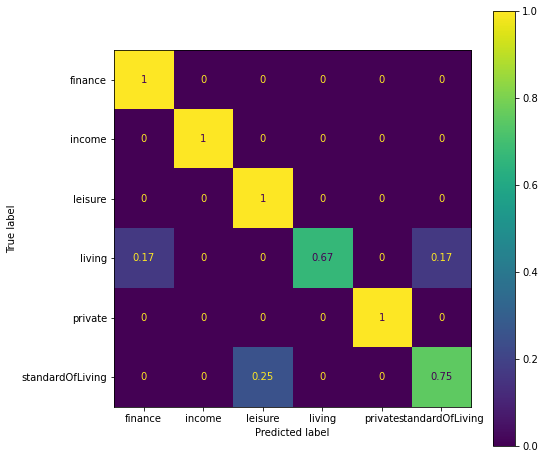

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, classification_report

def evaluate_prediction(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    
    print("accuracy: %.2f" % accuracy)
    print("precision: %.2f" % precision)
    print("recall: %.2f" % recall)
    print("f1 score: %.2f" % f1)
    
    print(classification_report(y_true, y_pred))

def train(X_train_features, y_train):
    # use 20% of training data for validation and hyperparameter tuning
    X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_val)

    # evaluation of the training
    evaluate_prediction(y_pred, y_val)
    plot_confusion_matrix(gnb, X_val, y_val, normalize="true")
    
    return gnb

gnb = train(X_train_features, y_train)

## Evaluation

To evaluate the performance of my classification model and test if it is able to generalize on new data I used the 25% of the dataset that was not used during training and is completely new to the classifer.

accuracy: 0.89
precision: 0.89
recall: 0.89
f1 score: 0.89
                  precision    recall  f1-score   support

         finance       1.00      1.00      1.00         8
          income       1.00      1.00      1.00         4
         leisure       0.93      0.82      0.87        17
          living       0.86      0.86      0.86         7
         private       0.67      0.80      0.73         5
standardOfLiving       0.85      0.92      0.88        12

        accuracy                           0.89        53
       macro avg       0.88      0.90      0.89        53
    weighted avg       0.89      0.89      0.89        53



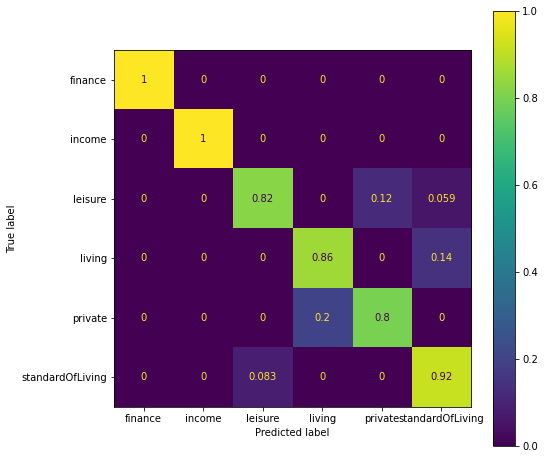

In [20]:
y_pred = gnb.predict(X_test_features)

evaluate_prediction(y_pred, y_test)
plot_confusion_matrix(gnb, X_test_features, y_test, normalize="true");

The accuracy reached 89% on the test dataset, which shows that the model can generalize on new data and did not overfit the training data.

The finance and income labels were predicted perfectly. The category private has the worst performance with only 80% accuracy.